In [2]:
import csv
import os
from functools import partial
import json

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)
from gerrychain.metrics import efficiency_gap, mean_median, polsby_popper
from gerrychain.proposals import recom, flip
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part

#import tqdm


In [3]:
unique_label = "GEOID10"
pop_col = "TOTPOP"
district_col = "CD"

plot_path = "./TX_vtds.shp"
graph = Graph.from_json("texas.json")

In [4]:
df = gpd.read_file(plot_path)

In [5]:
updaters = {
    "population": updaters.Tally("TOTPOP", alias="population"),
    "cut_edges": cut_edges, "black_pop": updaters.Tally("BPOP", alias = "black_pop"),
    "nh_white": updaters.Tally("NH_WHITE", alias = "nh_white"),
    "nh_black": updaters.Tally("NH_BLACK", alias = "nh_black"),
    "hisp": updaters.Tally("HISP", alias = "hisp"),
    "vap": updaters.Tally("VAP", alias = "vap"),
    "hvap": updaters.Tally("HVAP", alias = "hvap"),
    "wvap": updaters.Tally("WVAP", alias = "wvap"),
    "bvap":updaters.Tally("BVAP", alias = "bvap")
}

initial_partition = Partition(graph, "USCD", updaters)

In [14]:
num_dist = len(initial_partition.parts)
ideal_population = sum(initial_partition["population"].values()) / len(
    initial_partition)
random_plan = recursive_tree_part(graph, range(num_dist), ideal_population, "TOTPOP", 0.1, 1)
base_partition = Partition(graph, random_plan, updaters)
# random_plan_2 = recursive_tree_part(graph, range(num_dist), ideal_population, "TOTPOP", 0.001, 1)
# new_partition = Partition(graph, random_plan_2, updaters)

In [15]:
# Given a base_partition with some labelling and a new_partition, we would like 
# the labelling of new_partition to be as close as possible to the base_partition.
# That is, we would like as many nodes as possible to remain in the same district.
# This function implements a greedy algorithm to do so (thus is not necessarily optimal).
# It outputs a dictionary that takes the labelling given by base_partition and 
# says which label in new_partition should be sent to that base_partition label.  
# It also outputs the number of displaced nodes
# (so the output is a tuple with first entry the dictionary, second entry number of
# displaced nodes)

def greedy_hamming(base_partition, new_partition):
    names = [j for j in base_partition.parts]
    new_names = {}
    for i in new_partition.parts:
        intersection_sizes = {}
        for name in names:
            intersection_sizes.update({len(set(base_partition.assignment.parts[name]).intersection(set(new_partition.assignment.parts[i]))): name})
        new_names.update({intersection_sizes[max(intersection_sizes.keys())]: i})
        names.remove(intersection_sizes[max(intersection_sizes.keys())])
    tot_nodes = len(new_partition.assignment)
    final_int_sizes = []
    for i in base_partition.parts:
        x = len(set(new_partition.assignment.parts[new_names[i]]).intersection(set(base_partition.assignment.parts[i])))
        final_int_sizes.append(x)
    ham_dist = tot_nodes - sum(final_int_sizes)
    return new_names, ham_dist;

In [67]:
# Given a base_partition with some labelling and a new_partition, we would like 
# the labelling of new_partition to be as close as possible to the base_partition.
# That is, we would like as many people as possible to remain in the same district.
# This function implements a greedy algorithm to do so (thus is not necessarily optimal).
# It outputs a dictionary that takes the labelling given by base_partition and 
# says which label in new_partition should be sent to that base_partition label.  It also outputs the number of displaced people
# (so the output is a tuple with first entry the dictionary, second entry number of
# displaced people)


def greedy_hamming_pop(base_partition, new_partition):
    names = [j for j in base_partition.parts]
    new_names = {}
    for i in new_partition.parts:
        intersections = {}
        intersection_pops = {}
        for name in names:
            intersections.update({name: set(base_partition.assignment.parts[name]).intersection(set(new_partition.assignment.parts[i]))})
            intersection_pops.update({sum([new_partition.graph.nodes[node]["TOTPOP"] for node in intersections[name]]): name})
        new_names.update({intersection_pops[max(intersection_pops.keys())]: i})
        names.remove(intersection_pops[max(intersection_pops.keys())])
    tot_pop = sum(base_partition["population"].values())
    final_int_pops = []
    for i in base_partition.parts:
        intersection_set = set(new_partition.assignment.parts[new_names[i]]).intersection(set(base_partition.assignment.parts[i]))      
        intersection_list = list(intersection_set)
        intersection_pops = sum([new_partition.graph.nodes[node]["TOTPOP"] for node in intersection_list])
        final_int_pops.append(intersection_pops)
    ham_dist_pop = tot_pop - sum(final_int_pops)    
    return new_names, ham_dist_pop;

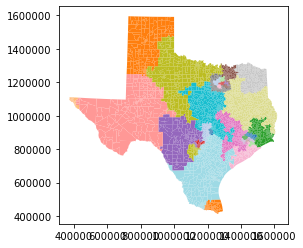

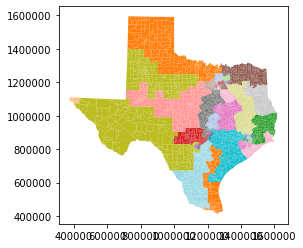

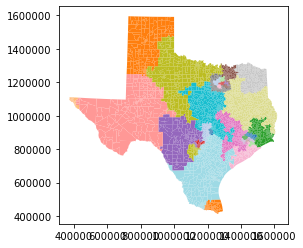

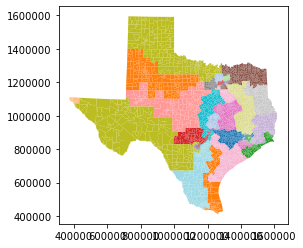

In [68]:
# Input: two partitions and the dataframe of their shapefile
# Output: Plots of the counties with labelling according to greedy_hamming
def partition_color_hamming(base_partition, new_partition, df):
    dist_dict = greedy_hamming(base_partition, new_partition)[0]
    df['old_dists'] = [base_partition.assignment[node] for node in base_partition.graph.nodes]
    df['new_plan'] = df.index.map(dict(new_partition.assignment))
    df['old_plan_new_colors'] = df["old_dists"].map(dist_dict)
    df.plot(column='new_plan', cmap = 'tab20')
    df.plot(column = 'old_plan_new_colors', cmap = 'tab20')

# Input: two partitions and the dataframe of their shapefile
# Output: Plots of the counties with labelling according to greedy_hamming_pop
def partition_color_pop(base_partition, new_partition, df):
    dist_dict = greedy_hamming_pop(base_partition, new_partition)[0]
    df['old_dists'] = [base_partition.assignment[node] for node in base_partition.graph.nodes]
    df['new_plan'] = df.index.map(dict(new_partition.assignment))
    df['old_plan_new_colors'] = df["old_dists"].map(dist_dict)
    df.plot(column='new_plan', cmap = 'tab20')
    df.plot(column = 'old_plan_new_colors', cmap = 'tab20')

partition_color_pop(initial_partition,base_partition,df)    
partition_color_hamming(initial_partition, base_partition, df)    

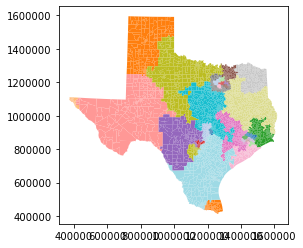

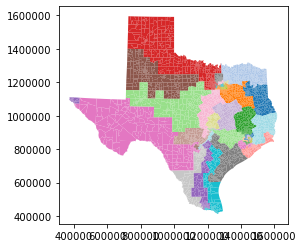

In [17]:
base_partition.plot(df, cmap = "tab20")


# In[116]:


initial_partition.plot(df, cmap = "tab20")



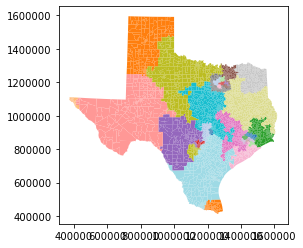

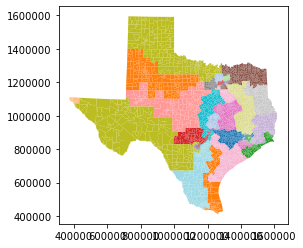

In [44]:
df['tree'] = df.index.map(dict(base_partition.assignment))
df['new_colors'] = df["USCD"].map(dist_dict)
df.plot(column='tree', cmap = 'tab20')
df.plot(column = 'new_colors', cmap = 'tab20')